In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision import transforms
import torch

In [3]:
df = pd.read_csv('data/diamond_data.csv')
print(df.head())
print(df.info())

                       path_to_img stock_number    shape  carat clarity  \
0  web_scraped/cushion/2106452.jpg      2106452  cushion   0.55     SI2   
1  web_scraped/cushion/2042329.jpg      2042329  cushion   0.52     SI2   
2  web_scraped/cushion/2055268.jpg      2055268  cushion   0.50     SI1   
3  web_scraped/cushion/2128779.jpg      2128779  cushion   0.50     VS2   
4  web_scraped/cushion/2103991.jpg      2103991  cushion   0.51     SI1   

  colour cut polish symmetry fluorescence  lab  length  width  depth  
0      N  VG     EX       VG            N  GIA    4.56   4.44   3.09  
1    Y-Z  EX     EX       VG            F  GIA    4.40   4.31   2.99  
2      L  VG     EX       VG            N  GIA    4.87   4.19   2.89  
3      M  EX     EX       VG            F  GIA    4.73   4.28   2.84  
4      M  EX     EX       VG            N  GIA    4.47   4.44   3.05  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48765 entries, 0 to 48764
Data columns (total 14 columns):
 #   Column   

In [4]:
# this is the code that will remove the path_to_img web_scraped/ from starting of the image path
df['path_to_img'] = df['path_to_img'].apply(lambda x: x.replace('web_scraped/', ''))

print(df.head())

           path_to_img stock_number    shape  carat clarity colour cut polish  \
0  cushion/2106452.jpg      2106452  cushion   0.55     SI2      N  VG     EX   
1  cushion/2042329.jpg      2042329  cushion   0.52     SI2    Y-Z  EX     EX   
2  cushion/2055268.jpg      2055268  cushion   0.50     SI1      L  VG     EX   
3  cushion/2128779.jpg      2128779  cushion   0.50     VS2      M  EX     EX   
4  cushion/2103991.jpg      2103991  cushion   0.51     SI1      M  EX     EX   

  symmetry fluorescence  lab  length  width  depth  
0       VG            N  GIA    4.56   4.44   3.09  
1       VG            F  GIA    4.40   4.31   2.99  
2       VG            N  GIA    4.87   4.19   2.89  
3       VG            F  GIA    4.73   4.28   2.84  
4       VG            N  GIA    4.47   4.44   3.05  


In [5]:
# Base directory where images are stored
base_dir = 'data/'

# Function to check if image exists
def check_image_exists(row):
    return os.path.exists(os.path.join(base_dir, row['path_to_img']))

# Apply the function to create a new column indicating image existence
df['image_exists'] = df.apply(check_image_exists, axis=1)

# Summary of image existence
print(df['image_exists'].value_counts())


image_exists
True    48765
Name: count, dtype: int64


In [6]:
# Remove entries with missing images
df = df[df['image_exists'] == True].drop(columns=['image_exists'])

In [7]:
target_col = 'shape'

# Identify numeric and categorical columns (adjust as per dataset)
numeric_cols = ['carat', 'length', 'width', 'depth']
categorical_cols = ['clarity', 'colour', 'cut', 'polish', 'symmetry', 'fluorescence', 'lab']

# Handle missing values
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].mean())

for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

# Drop rows with missing target values
df = df.dropna(subset=[target_col])

# One-hot encode categorical features
df = pd.get_dummies(df, columns=categorical_cols)

# Encode the target as numeric
target_classes = df[target_col].unique()
class_to_idx = {cls: idx for idx, cls in enumerate(target_classes)}
df['target_class'] = df[target_col].map(class_to_idx)

# Drop the original target column now that we have 'target_class'
df = df.drop(columns=[target_col])

# Scale numeric features manually
for col in numeric_cols:
    mean_val = df[col].mean()
    std_val = df[col].std()
    df[col] = (df[col] - mean_val) / (std_val + 1e-8)

# Shuffle the data before splitting
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into train, val, test
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

n = len(df)
train_end = int(train_ratio * n)
val_end = int((train_ratio + val_ratio) * n)

train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

Train size: 34135
Validation size: 7315
Test size: 7315


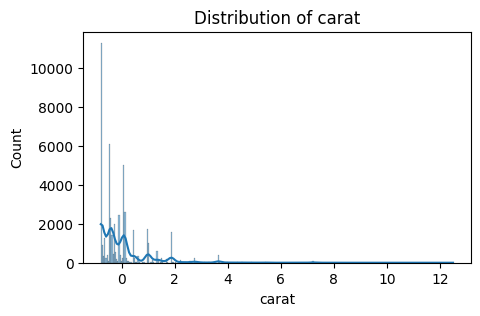

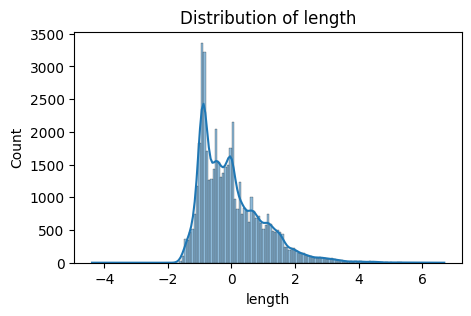

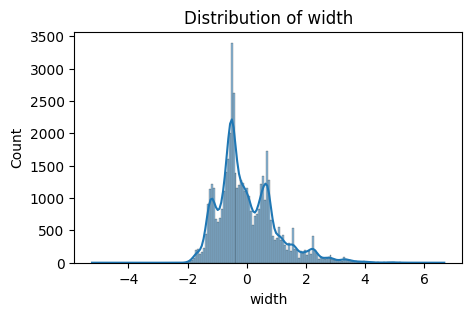

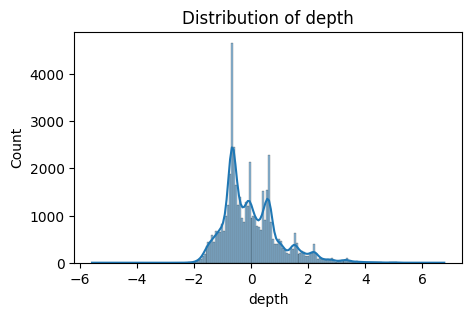

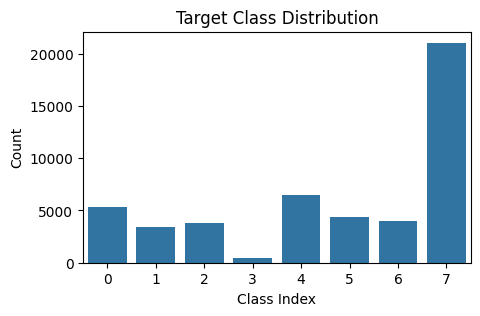

Class distribution:
 target_class
7    21032
4     6492
0     5341
5     4338
6     3949
2     3756
1     3392
3      465
Name: count, dtype: int64


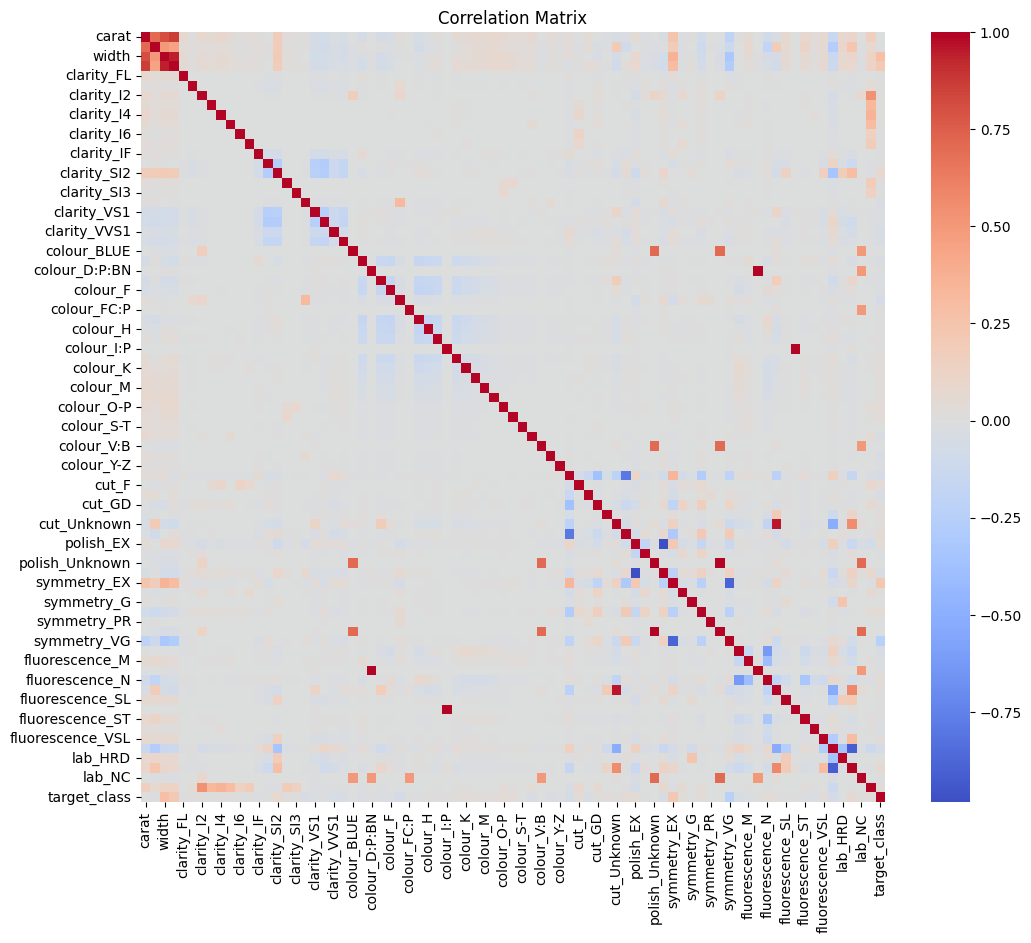

Features correlation with the target_class:
target_class    1.000000
width           0.285982
symmetry_EX     0.218832
depth           0.213654
clarity_SI2     0.083681
                  ...   
clarity_VVS1   -0.051980
cut_EX         -0.055603
lab_GIA        -0.062073
colour_FANCY   -0.066269
symmetry_VG    -0.241535
Name: target_class, Length: 79, dtype: float64


In [8]:
# 3.1 Distribution of numeric features
for col in numeric_cols:
    plt.figure(figsize=(5,3))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# 3.2 Target variable distribution
target_counts = df['target_class'].value_counts()
plt.figure(figsize=(5,3))
sns.barplot(x=target_counts.index, y=target_counts.values)
plt.title("Target Class Distribution")
plt.xlabel("Class Index")
plt.ylabel("Count")
plt.show()

print("Class distribution:\n", target_counts)

# 3.3 Correlation matrix
# Identify feature columns (excluding 'target_class', 'path_to_img', 'stock_number')
exclude_cols = ['target_class', 'path_to_img', 'stock_number'] 
feature_cols = [c for c in df.columns if c not in exclude_cols]

corr = df[feature_cols + ['target_class']].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

# Check correlation with target variable
target_corr = corr['target_class'].sort_values(ascending=False)
print("Features correlation with the target_class:")
print(target_corr)